**ПРОЕКТ 4: Авиарейсы без потерь**



# Что вы успеете сделать в этом проекте?

- Применить все базовые операторы SQL.
- Поработать с базой данных, соединением и объединением таблиц.
- Научиться самостоятельно подбирать данные для аналитической задачи.

## **База данных находится в учебном Metabase и называется** dst_project. 

## *Ссылка на базу данных*: http://sql.skillfactory.ru:3000/ 

# Постановка задачи проекта 4:

- Напомним, что вам предстоит выяснить, от каких самых малоприбыльных рейсов из Анапы мы можем отказаться в зимнее время. Вы не знаете, по каким критериям ваше руководство будет отбирать рейсы, поэтому решаете собрать как можно больше информации, содержащейся в вашей базе, в один датасет. 

- Исходя из того, что прибыльность рейса — это разница между доходом от продаж билетов и расходом на полет, соберите такой датасет, который позволит оценить эти цифры. 

- Самая простая модель оценки прибыльности: стоимость билетов - стоимость топлива на рейс (для оценки последнего вам необходим километраж рейса или длительность полета), но вы можете предложить другую модель.

- Ваш датасет должен обязательно включать id рейса и города вылета (Анапа) и прилета. Он также  может включать такие данные, как модель самолёта и его характеристики, суммарную стоимость всех билетов на рейсе, затраченное время в полёте и прочее — на ваше усмотрение.

# **ШАГ 0. Подготовка ноутбука. Загрузка датасета. Структура датасета.**

**Важно!**

- Код решения этих задач вы отправите на проверку ментору, так что сохраняйте его в текстовом документе или сразу на GitHub. 
- Не забудьте о том, что в оформлении кода запросов есть свои стандарты. 
- Рекомендуем вам ознакомиться с Руководством по стилю SQL, а также пользоваться инструментом для форматирования кода

**Примечание:** 

прибыльность рейса - разница между доходом от продажи билетов и расходом на полет (топливо с учетом оборотного рейса).

**Структура датасета:**

Датасет, выгруженный из Metabase, состоит из 23 столбцов, содержащих следующую информацию:

 - 0   id_рейса 
 - 1   Аэропорт_вылета
 - 2   Аэропорт_прилета 
 - 3   Город_вылета 
 - 4   Дата_вылета
 - 5   Месяц_вылета
 - 6   Год_вылета
 - 7   Длительность
 - 8   Время_полёта_в_минутах
 - 9   Модель_самолета 
 - 10  Макс_дальность_полета  
 - 11  Код_самолета_iata 
 - 12  Количество_мест  
 - 13  max_допустимое_колво_свободных_мест
 - 14  Количество_свободных_мест
 - 15  Количество_купленных_билетов
 - 16  Класс_обслуживания
 - 17  Класс_Эконом  
 - 18  Класс_Комфорт  
 - 19  Класс_Бизнес  
 - 20  Доход_от_продажи_билетов_рублей
 - 21  Расход_на_топливо_рублей
 - 22  Прибыльность_рейса_рублей

In [1]:
# Загрузка библиотек:

import pandas as pd
import numpy as np
import ast
import datetime as dt
import io

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


In [2]:
from datetime import datetime, date, time, timedelta
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [3]:
# Иструмент для кодирования
from sklearn.preprocessing import LabelEncoder
import re

In [4]:
# Загрузка классов из библиотек

from pprint import pprint

pd.set_option('display.max_columns', None)


In [5]:
# Загрузка датасета размером 360 записей - данные о рейсах в зимний период в 2017 году
# 360 записей = 180 записей ECONOMY + 180 записей BUSINESS

data = pd.read_csv('df_final_unit-4.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id_рейса                             360 non-null    int64  
 1   Аэропорт_вылета                      360 non-null    object 
 2   Аэропорт_прилета                     360 non-null    object 
 3   Город_вылета                         360 non-null    object 
 4   Дата_вылета                          360 non-null    float64
 5   Месяц_вылета                         360 non-null    float64
 6   Год_вылета                           360 non-null    float64
 7   Длительность                         360 non-null    object 
 8   Время_полёта_в_минутах               360 non-null    float64
 9   Модель_самолета                      360 non-null    object 
 10  Макс_дальность_полета                360 non-null    int64  
 11  Код_самолета_iata               

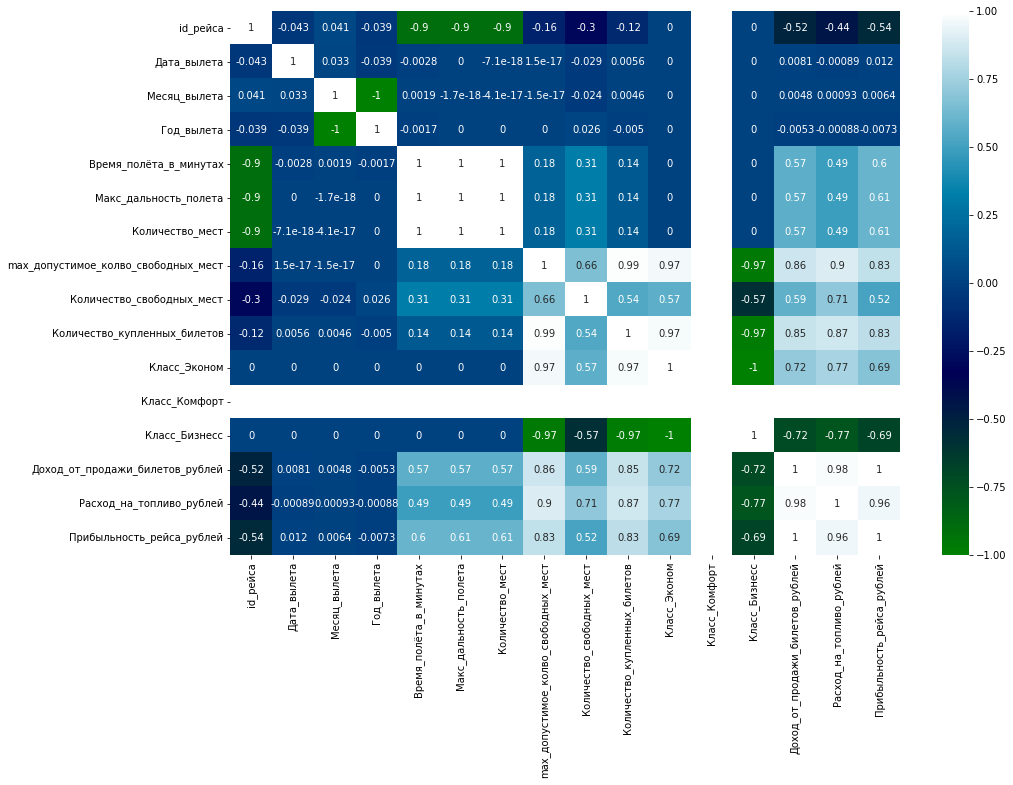

In [123]:
sns.heatmap(data.corr(), annot=True, cmap='ocean')
fig = plt.gcf()
fig.set_size_inches(15, 10)

**ВЫВОД по первому знакомству с исходным датасетом, выгруженным из MetaBase:**

- исходный датасет содержит 23 признака
- **целевой признак:** *Прибыльность_рейса_рублей*
- этот признак зависит от заполненности рейса, т.е. отсутствия свободных мест
- **признак:** *max_допустимое_колво_свободных_мест* - определяет критерий оценки допустимой незаполненности мест на рейсе - максимум 25% общего количества мест может быть незаполнена. При этом считается, что рейс обеспечивает минимальную рентабельность
- проанализируем загрузку рейсов, всего 180 рейсов вылетает из г.Анапа в зимний период 2017 года, включая декабрь 2016 года и декабрь 2017 года
- для анализа данных удалим из исходного датасета малозначимые признаки (**переходим к ШАГ 1**)

# **ШАГ 1. Формируем датасеты для анализа.**

Примечание: всего три датасета на основе исходного. выгруженного из MetaBase.

- **ДАТАСЕТ 1: 19 признаков**

In [ ]:
# сформируем датасет для анализа прибыли в зависимости:
#  от класса обслуживания,
#  от месяца вылета,
#  от дальности полета

In [120]:
df_1=data.copy(deep=True)

In [121]:
df_1 = df_1.drop(['Город_вылета', 'Длительность', 'Макс_дальность_полета','Класс_обслуживания'], axis = 1)

In [122]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id_рейса                             360 non-null    int64  
 1   Аэропорт_вылета                      360 non-null    object 
 2   Аэропорт_прилета                     360 non-null    object 
 3   Дата_вылета                          360 non-null    float64
 4   Месяц_вылета                         360 non-null    float64
 5   Год_вылета                           360 non-null    float64
 6   Время_полёта_в_минутах               360 non-null    float64
 7   Модель_самолета                      360 non-null    object 
 8   Код_самолета_iata                    360 non-null    object 
 9   Количество_мест                      360 non-null    int64  
 10  max_допустимое_колво_свободных_мест  360 non-null    float64
 11  Количество_свободных_мест       

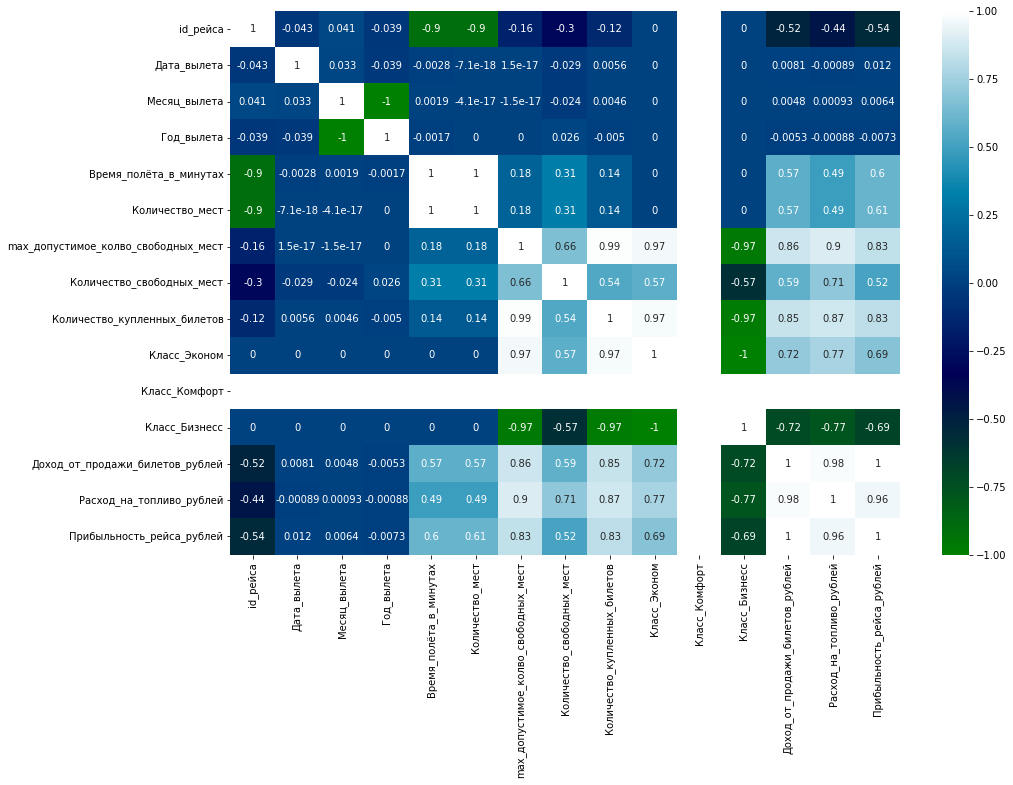

In [124]:
sns.heatmap(df_1.corr(), annot=True, cmap='ocean')
fig = plt.gcf()
fig.set_size_inches(15, 10)

- **ДАТАСЕТ 2: 10 признаков**

In [ ]:
# сформуруем датасет для анализа максимально допустимого количества свободных мест в зависимости:
#  от класса обслуживания,
#  от месяца вылета,
#  от дальности полета,
#  по рейсам,
#  по городам прилета
#  по датам вылета

In [65]:
df_2=data.copy(deep=True)

In [66]:
df_2 = df_2.drop(['Аэропорт_вылета', 'Аэропорт_прилета', 'Время_полёта_в_минутах', 
                  'Код_самолета_iata', 'Количество_мест','Количество_купленных_билетов',
                  'Класс_Комфорт', 'Доход_от_продажи_билетов_рублей','Расход_на_топливо_рублей', 'Город_вылета', 
                  'Длительность', 'Макс_дальность_полета', 
                  'Макс_дальность_полета', 'Класс_обслуживания'], axis = 1)

In [67]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id_рейса                             360 non-null    int64  
 1   Дата_вылета                          360 non-null    float64
 2   Месяц_вылета                         360 non-null    float64
 3   Год_вылета                           360 non-null    float64
 4   Модель_самолета                      360 non-null    object 
 5   max_допустимое_колво_свободных_мест  360 non-null    float64
 6   Количество_свободных_мест            360 non-null    int64  
 7   Класс_Эконом                         360 non-null    int64  
 8   Класс_Бизнесс                        360 non-null    int64  
 9   Прибыльность_рейса_рублей            360 non-null    float64
dtypes: float64(5), int64(4), object(1)
memory usage: 28.2+ KB


In [68]:
# уникальные номера рейсов

df_2.id_рейса.sort_values().unique()

array([136119, 136120, 136122, 136130, 136131, 136132, 136135, 136141,
       136143, 136146, 136159, 136164, 136165, 136172, 136178, 136181,
       136185, 136187, 136202, 136204, 136207, 136209, 136210, 136215,
       136223, 136226, 136244, 136249, 136250, 136252, 136253, 136257,
       136262, 136264, 136266, 136268, 136269, 136270, 136273, 136275,
       136282, 136284, 136293, 136296, 136306, 136310, 136316, 136318,
       136320, 136322, 136324, 136327, 136338, 136345, 136348, 136351,
       136352, 136360, 136366, 136368, 136383, 136385, 136387, 136389,
       136390, 136391, 136397, 136403, 136411, 136418, 136420, 136423,
       136428, 136436, 136439, 136441, 136447, 136450, 136452, 136458,
       136463, 136464, 136465, 136471, 136474, 136479, 136485, 136486,
       136491, 136492, 136571, 136586, 136592, 136600, 136605, 136609,
       136612, 136617, 136620, 136630, 136631, 136632, 136642, 136645,
       136649, 136653, 136654, 136660, 136661, 136666, 136669, 136672,
      

In [72]:
df_2.sort_values(by =['Количество_свободных_мест'], ascending=False).head(20)

,id_рейса,Дата_вылета,Месяц_вылета,Год_вылета,Модель_самолета,max_допустимое_колво_свободных_мест,Количество_свободных_мест,Класс_Эконом,Класс_Бизнесс,Прибыльность_рейса_рублей
61,136253,24.0,12.0,2016.0,Boeing 737-300,29.50,36,1,0,675899.877333
113,136352,10.0,12.0,2016.0,Boeing 737-300,29.50,36,1,0,670379.466667
115,136360,5.0,2.0,2017.0,Boeing 737-300,29.50,32,1,0,716779.466667
205,136642,30.0,1.0,2017.0,Sukhoi Superjet-100,21.25,31,1,0,238138.228000
5,136122,8.0,1.0,2017.0,Boeing 737-300,29.50,31,1,0,728979.466667
139,136418,7.0,12.0,2016.0,Boeing 737-300,29.50,30,1,0,742379.466667
37,136202,5.0,1.0,2017.0,Boeing 737-300,29.50,29,1,0,750259.056000
29,136178,29.0,1.0,2017.0,Boeing 737-300,29.50,28,1,0,772539.672000
57,136250,8.0,2.0,2017.0,Boeing 737-300,29.50,27,1,0,775619.261333
59,136252,20.0,12.0,2016.0,Boeing 737-300,29.50,27,1,0,775619.261333


In [95]:
df_2.groupby(['id_рейса',
              'Количество_свободных_мест'])['max_допустимое_колво_свободных_мест'].value_counts(ascending=True).head(20)


id_рейса  Количество_свободных_мест  max_допустимое_колво_свободных_мест
136119    1                          3.0                                    1
          16                         29.5                                   1
136120    1                          3.0                                    1
          20                         29.5                                   1
136122    2                          3.0                                    1
          31                         29.5                                   1
136130    2                          3.0                                    1
          21                         29.5                                   1
136131    0                          3.0                                    1
          6                          29.5                                   1
136132    0                          3.0                                    1
          14                         29.5                            

In [108]:
df_2_failedflights.id_рейса.value_counts().head(10)
# наименее рентабельный рейс 136807, вылетающий 23.02.2017 года - критерий: количество не проданных билетов
# рейс 136807 - Sukhoi Superjet-100

136807    2
136383    1
136397    1
136418    1
136486    1
136360    1
136642    1
136204    1
136844    1
136253    1
Name: id_рейса, dtype: int64

- **Вывод:**

  наименее рентабельный рейс 136807 - Sukhoi Superjet-100

  вылетающий 23.02.2017 года
  критерий оценки рентабельности: количество не проданных билетов (4 билета в бизнес-классе, 25 билетов в эконом-классе при максимальном пороге свободных мест: 3 и 21.25, соответственно.
  
  рекомендация: сделать скидки на билеты бизнес-класса для 100% заполнения рейса

In [118]:
df_2_failedflights.Прибыльность_рейса_рублей.sort_values().head(5)


304     98398.066667
288    136198.066667
328    136498.105333
38     185553.866667
132    221813.405333
Name: Прибыльность_рейса_рублей, dtype: float64

- **Вывод:**

  наименее рентабельный рейс 136844 - Sukhoi Superjet-100

  вылетающий 28.02.2017 года
  критерий оценки рентабельности: минимальная прибыль и наличие 6 непроданных билетов в бизнес-классе
  
  рекомендация: сделать скидки на билеты бизнес-класса для 100% заполнения рейса

- **Выделим из датасета df_2** только те рейсы, которые являются сомнительными в части рентабельности:

In [109]:
df_2_failedflights=df_2.query('Количество_свободных_мест>max_допустимое_колво_свободных_мест')
df_2_failedflights.sort_values(by=['Прибыльность_рейса_рублей'], ascending=True).head(20)

,id_рейса,Дата_вылета,Месяц_вылета,Год_вылета,Модель_самолета,max_допустимое_колво_свободных_мест,Количество_свободных_мест,Класс_Эконом,Класс_Бизнесс,Прибыльность_рейса_рублей
304,136844,28.0,2.0,2017.0,Sukhoi Superjet-100,3.00,6,0,1,98398.066667
288,136807,23.0,2.0,2017.0,Sukhoi Superjet-100,3.00,4,0,1,136198.066667
328,136887,20.0,1.0,2017.0,Sukhoi Superjet-100,3.00,4,0,1,136498.105333
38,136204,23.0,2.0,2017.0,Boeing 737-300,3.00,6,0,1,185553.866667
132,136397,25.0,12.0,2016.0,Boeing 737-300,3.00,5,0,1,221813.405333
162,136464,9.0,1.0,2017.0,Boeing 737-300,3.00,5,0,1,222153.866667
205,136642,30.0,1.0,2017.0,Sukhoi Superjet-100,21.25,31,1,0,238138.228000
120,136383,25.0,1.0,2017.0,Boeing 737-300,3.00,4,0,1,258072.944000
174,136486,2.0,2.0,2017.0,Boeing 737-300,3.00,4,0,1,258413.405333
56,136250,8.0,2.0,2017.0,Boeing 737-300,3.00,4,0,1,258413.405333


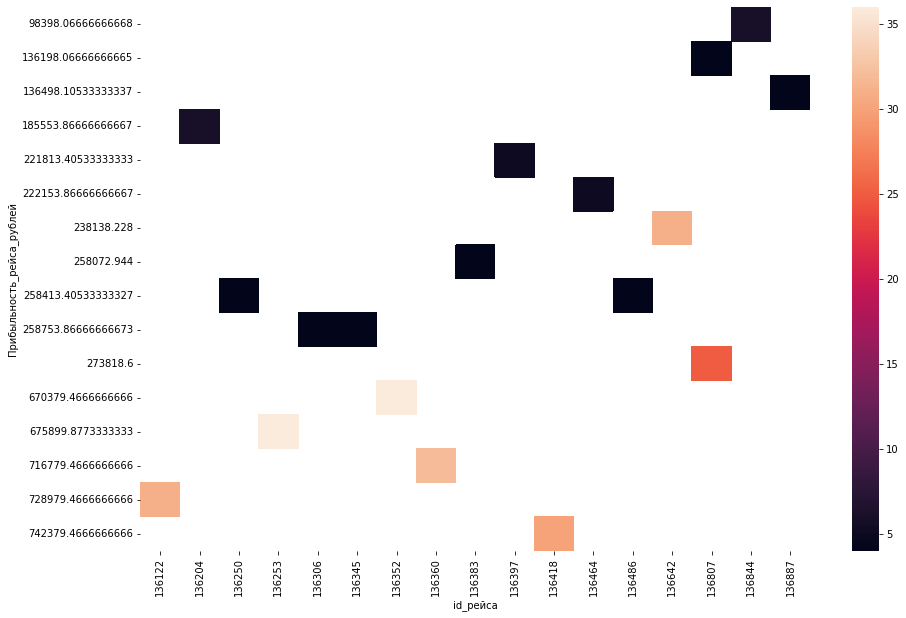

In [148]:
flights = df_2_failedflights.pivot("Прибыльность_рейса_рублей", "id_рейса", "Количество_свободных_мест")
ax = sns.heatmap(flights)
fig = plt.gcf()
fig.set_size_inches(15, 10)

- **Вывод:**

  еще один рейс с невысокой рентабельностьюс 136887 - Sukhoi Superjet-100

  вылетающий 20.01.2017 года
  критерий оценки рентабельности: минимальная прибыль и наличие 4 непроданных билетов в бизнес-классе
  
  рекомендация: сделать скидки на билеты бизнес-класса для 100% заполнения рейса

- **ДАТАСЕТ 3: 7 признаков**

In [ ]:
# сформуруем датасет для прибыльности рейсов (id_рейса) в зависимости:
#  от Прибыльность_рейса_рублей,
#  от max_допустимое_колво_свободных_мест,
#  от Количество_свободных_мест,
#  от класса обслуживания: Эконом или Бизнес,
#  от даты вылета
#  от месяца вылета

In [140]:
df_3=data.copy(deep=True)

In [141]:
df_3 = df_3.drop(['Город_вылета', 'Длительность', 'Макс_дальность_полета', 
                  'Макс_дальность_полета', 'Класс_обслуживания',
                  'Аэропорт_вылета', 'Аэропорт_прилета', 'Месяц_вылета', 'Год_вылета', 'Модель_самолета', 'Время_полёта_в_минутах', 
                  'Код_самолета_iata', 'Количество_мест','Количество_купленных_билетов',
                  'Класс_Комфорт', 'Доход_от_продажи_билетов_рублей','Расход_на_топливо_рублей'], axis = 1)

In [142]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id_рейса                             360 non-null    int64  
 1   Дата_вылета                          360 non-null    float64
 2   max_допустимое_колво_свободных_мест  360 non-null    float64
 3   Количество_свободных_мест            360 non-null    int64  
 4   Класс_Эконом                         360 non-null    int64  
 5   Класс_Бизнесс                        360 non-null    int64  
 6   Прибыльность_рейса_рублей            360 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 19.8 KB


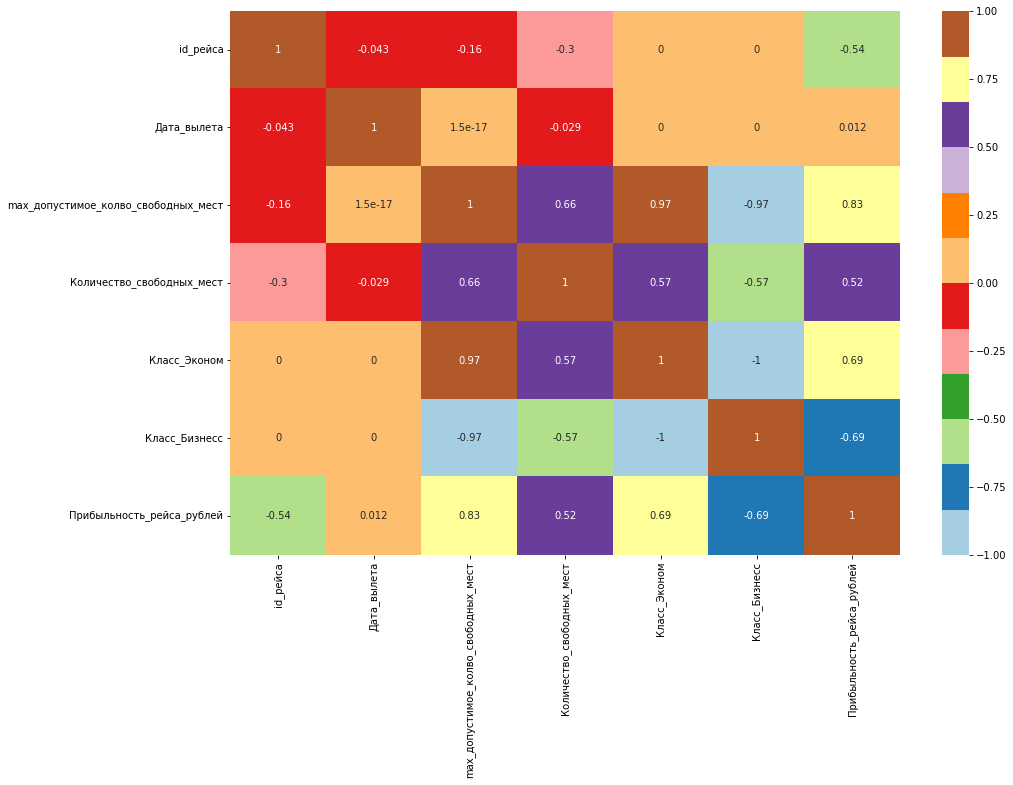

In [143]:
sns.heatmap(df_3.corr(), annot=True, cmap='Paired')
fig = plt.gcf()
fig.set_size_inches(15, 10)

# **ШАГ 2. Анализ данных.**

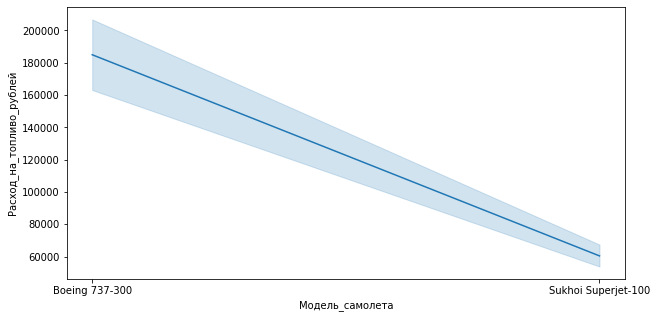

In [172]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_1, x='Модель_самолета', y='Расход_на_топливо_рублей');

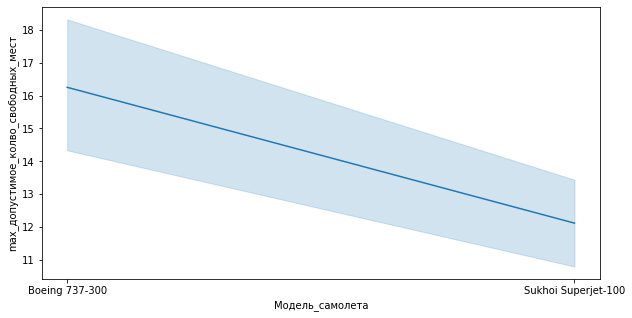

In [30]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_1, x='Модель_самолета', y='max_допустимое_колво_свободных_мест');

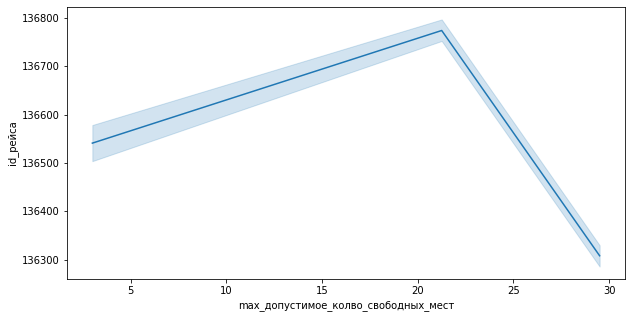

In [137]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_1, x='max_допустимое_колво_свободных_мест', y='id_рейса');

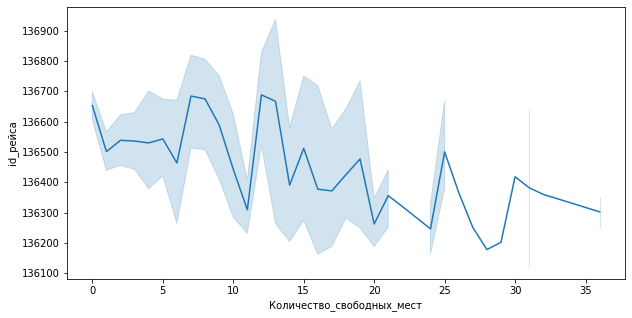

In [138]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_1, x='Количество_свободных_мест', y='id_рейса');

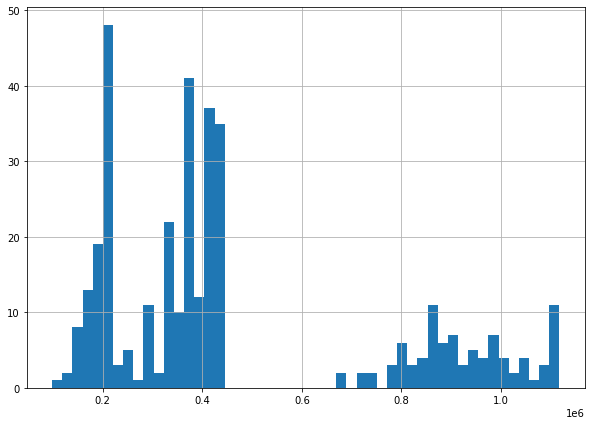

In [178]:
# Посмотрим распределение Прибыльности рейса

plt.rcParams['figure.figsize'] = (10,7)
df_3['Прибыльность_рейса_рублей'].hist(bins=50)

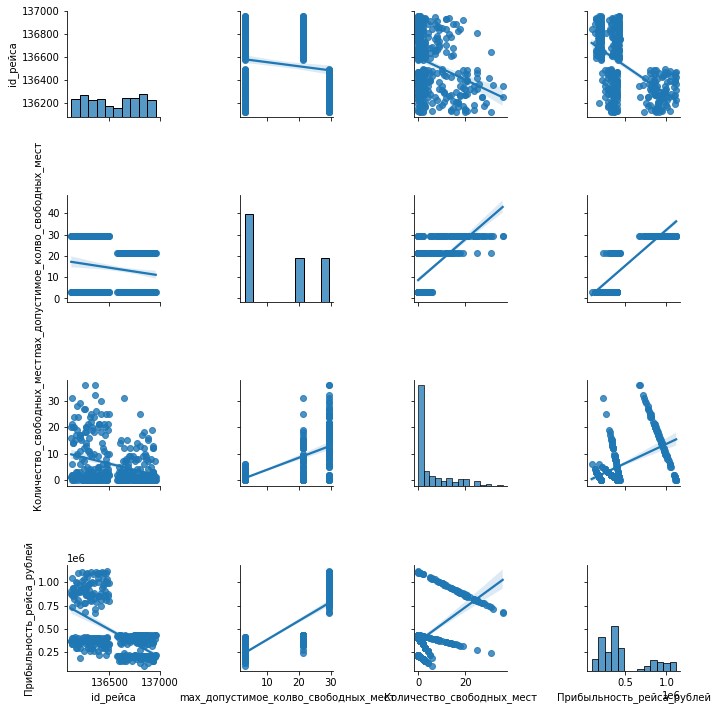

In [144]:
model = ['id_рейса', 'max_допустимое_колво_свободных_мест', 'Количество_свободных_мест', 'Прибыльность_рейса_рублей']

sns.pairplot(df_3[model], kind='reg');

In [145]:
df_3[model].corr()

,id_рейса,max_допустимое_колво_свободных_мест,Количество_свободных_мест,Прибыльность_рейса_рублей
id_рейса,1.000000,-0.161407,-0.299166,-0.543842
max_допустимое_колво_свободных_мест,-0.161407,1.000000,0.659912,0.830862
Количество_свободных_мест,-0.299166,0.659912,1.000000,0.522182
Прибыльность_рейса_рублей,-0.543842,0.830862,0.522182,1.000000


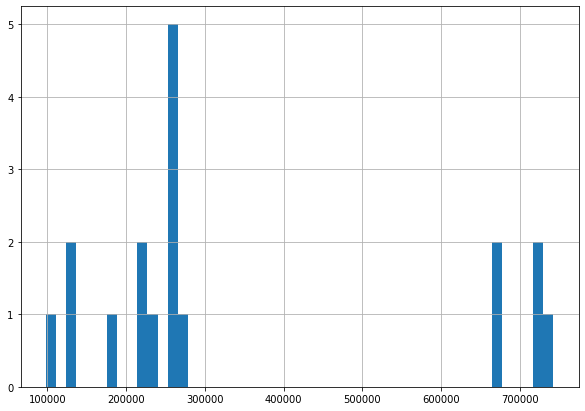

In [179]:
# Посмотрим распределение Прибыльности рейса

plt.rcParams['figure.figsize'] = (10,7)
df_2_failedflights['Прибыльность_рейса_рублей'].hist(bins=50)

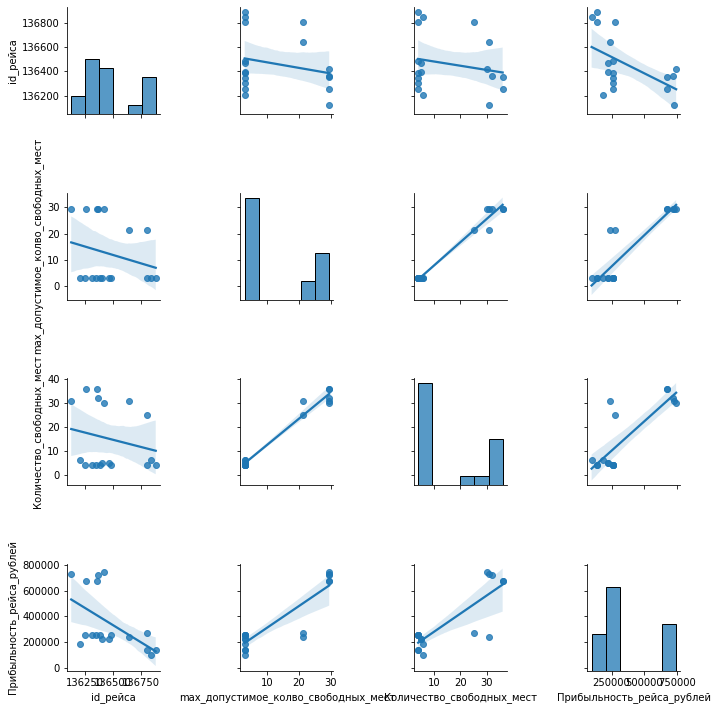

In [151]:
model_1 = ['id_рейса', 'max_допустимое_колво_свободных_мест', 'Количество_свободных_мест', 'Прибыльность_рейса_рублей']

sns.pairplot(df_2_failedflights[model_1], kind='reg');



In [152]:
df_2_failedflights[model_1].corr()

,id_рейса,max_допустимое_колво_свободных_мест,Количество_свободных_мест,Прибыльность_рейса_рублей
id_рейса,1.000000,-0.240059,-0.203889,-0.532200
max_допустимое_колво_свободных_мест,-0.240059,1.000000,0.987269,0.892917
Количество_свободных_мест,-0.203889,0.987269,1.000000,0.833654
Прибыльность_рейса_рублей,-0.532200,0.892917,0.833654,1.000000


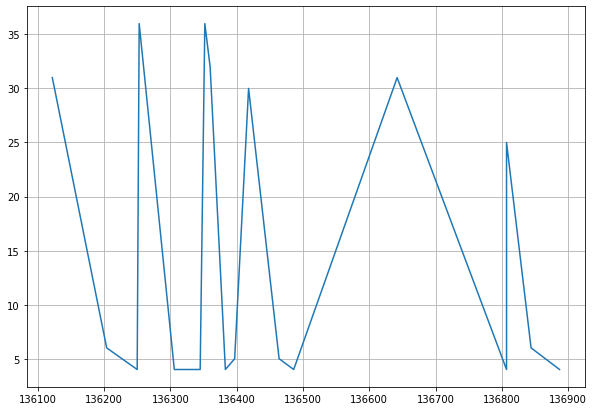

In [153]:
# построение графика параболы
plt.plot(df_2_failedflights.id_рейса, df_2_failedflights.Количество_свободных_мест) 

# включим сетку на графике 
plt.grid(True)

# показать график
plt.show()

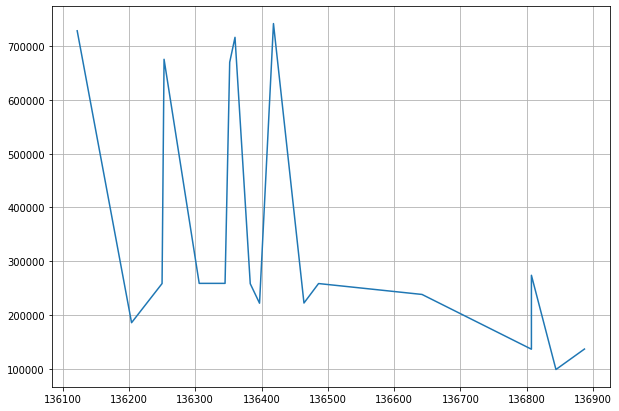

In [187]:
# построение графика параболы
plt.plot(df_2_failedflights.id_рейса, df_2_failedflights.Прибыльность_рейса_рублей) 

# включим сетку на графике 
plt.grid(True)

# показать график
plt.show()

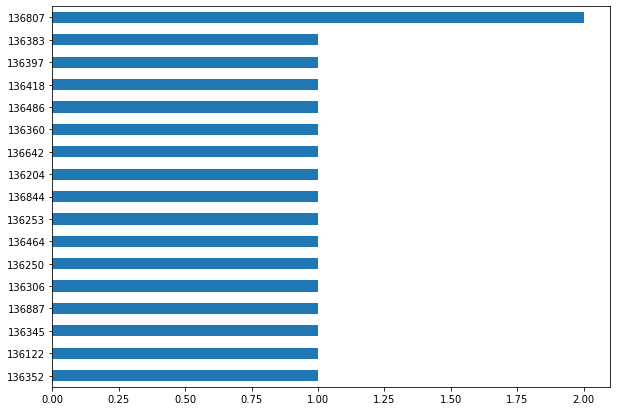

In [150]:
# посмотрим распределение рейсов:

df_2_failedflights['id_рейса'].value_counts(ascending=True).plot(kind='barh')

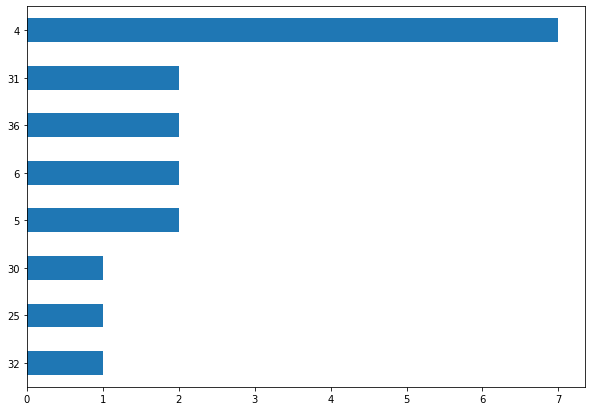

In [154]:
# посмотрим распределение рейсов:

df_2_failedflights['Количество_свободных_мест'].value_counts(ascending=True).plot(kind='barh')

In [166]:
def get_boxplot_1(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='Прибыльность_рейса_рублей', 
                data=df_2_failedflights.loc[df_2_failedflights.loc[:, column].isin(df_2_failedflights.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

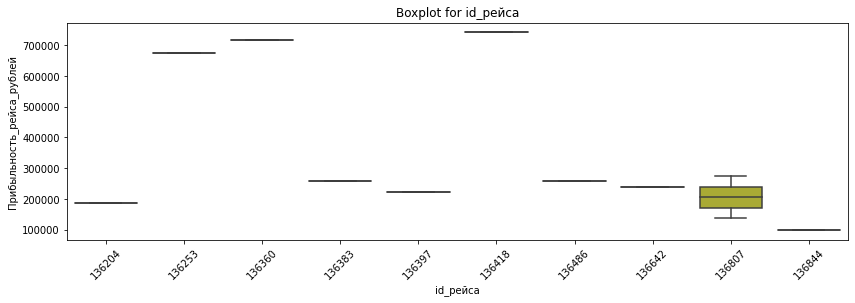

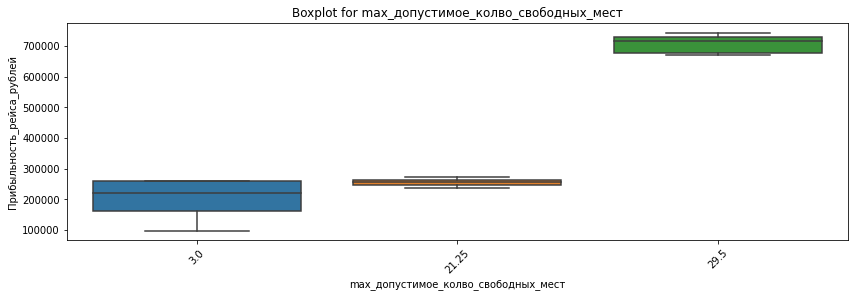

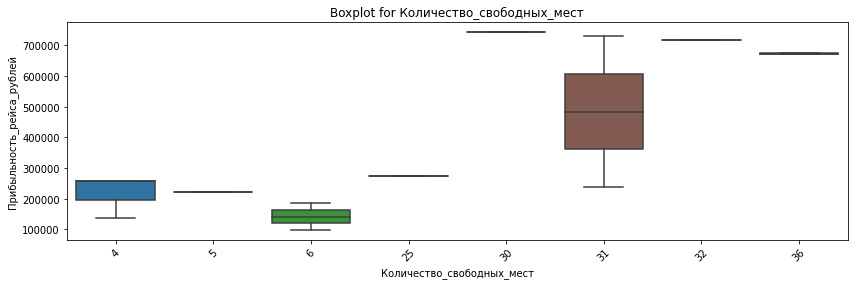

In [167]:
#используем для анализа только влияющие переменные, оставшиеся в датасете - 13 переменных, без учёта переменной score
for col in ['id_рейса', 'max_допустимое_колво_свободных_мест', 'Количество_свободных_мест']:
    get_boxplot_1(col)

In [192]:
def get_boxplot_2(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='Количество_свободных_мест', 
                data=df_2_failedflights.loc[df_2_failedflights.loc[:, column].isin(df_2_failedflights.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

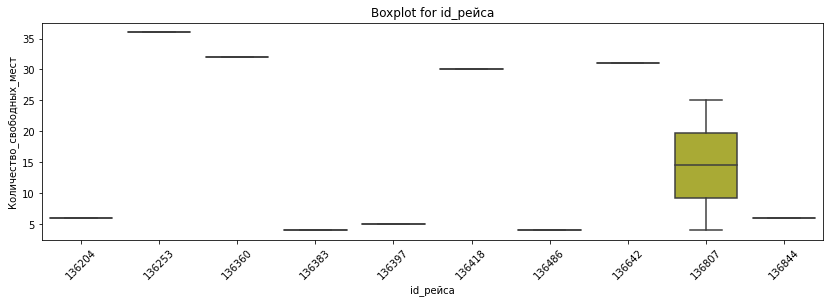

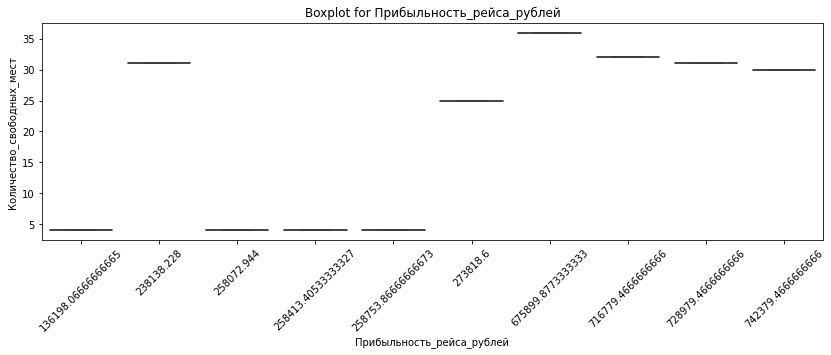

In [193]:
#используем для анализа только влияющие переменные, оставшиеся в датасете - 13 переменных, без учёта переменной score
for col in ['id_рейса', 'Прибыльность_рейса_рублей']:
    get_boxplot_2(col)

# **ВЫВОД по задаче.**

# ДАННЫХ для АНАЛИЗА малова-то :), но даже при таком количестве анализируемых данных можно сделать следующие выводы и рекомендации:

-   **наименее рентабельный рейс 136844** - Sukhoi Superjet-100;  вылетающий **28.02.2017 года**; критерий оценки рентабельности: минимальная прибыль (98398.07 рублей) и наличие 6 непроданных билетов в бизнес-классе. **Рекомендация:** сделать скидки на билеты бизнес-класса для 100% заполнения рейса.

- **наименее рентабельный рейс 136807** - Sukhoi Superjet-100; вылетающий **23.02.2017 года**; критерий оценки рентабельности: количество не проданных билетов (4 билета в бизнес-классе, 25 билетов в эконом-классе при максимальном пороге свободных мест: 3 и 21.25, соответственно. **Рекомендация:** сделать скидки на билеты бизнес-класса для 100% заполнения рейса.

- **наименее рентабельный рейс 136887** - Sukhoi Superjet-100;  вылетающий **20.01.2017 года**; критерий оценки рентабельности: минимальная прибыль (136498.105 рублей) и наличие 4 непроданных билетов в бизнес-классе. **Рекомендация:** сделать скидки на билеты бизнес-класса для 100% заполнения рейса.


# Результаты по проекту загружены:

- презентация о проекте на Гуугл-диск по ссылке:
[https://docs.google.com/presentation/d/1fDl5owPLucxZ3ot_g1G2gcBKMs6rIRyl/edit?usp=sharing&ouid=117746281581230185717&rtpof=true&sd=true]

- ноутбук с анализом данных о рейсах и исходный датасет, выгруженный из Metabase на GitHub по ссылке:
[https://github.com/47petrov/SkillFactory/tree/main/Unit_4]